In [1]:
# Install dependencies if needed
!pip install tensorflow pandas numpy matplotlib zipfile36



In [2]:
import os
import numpy as np
import pandas as pd
import zipfile
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [3]:
from google.colab import files

# Upload kaggle.json (your Kaggle API key)
files.upload()




Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shettynaisha","key":"782221b40ceeff6077b00d384c9ed96e"}'}

In [4]:
import os

# Move kaggle.json to ~/.kaggle (required for authentication)
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Secure the file


In [5]:
# Download the dataset
!kaggle datasets download -d manjilkarki/deepfake-and-real-images


Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown


In [6]:
import zipfile

# Extract the downloaded ZIP file
dataset_zip = "deepfake-and-real-images.zip"
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("dataset")  # Extract to "dataset" folder

print("✅ Dataset downloaded and extracted successfully!")




✅ Dataset downloaded and extracted successfully!


In [7]:
# Show extracted folder contents
!ls dataset/Dataset



Test  Train  Validation


In [8]:
!ls dataset/Dataset/Train
!ls dataset/Dataset/Test
!ls dataset/Dataset/Validation


Fake  Real
Fake  Real
Fake  Real


In [9]:
#Count Real and Fake Images
import os

# Define correct paths
train_real = "dataset/Dataset/Train/Real"
train_fake = "dataset/Dataset/Train/Fake"

test_real = "dataset/Dataset/Test/Real"
test_fake = "dataset/Dataset/Test/Fake"

val_real = "dataset/Dataset/Validation/Real"
val_fake = "dataset/Dataset/Validation/Fake"

#  Count images in each category
train_real_count = len(os.listdir(train_real))
train_fake_count = len(os.listdir(train_fake))
test_real_count = len(os.listdir(test_real))
test_fake_count = len(os.listdir(test_fake))
val_real_count = len(os.listdir(val_real))
val_fake_count = len(os.listdir(val_fake))

print(f"✅ Train - Real: {train_real_count}, Fake: {train_fake_count}")
print(f"✅ Test - Real: {test_real_count}, Fake: {test_fake_count}")
print(f"✅ Validation - Real: {val_real_count}, Fake: {val_fake_count}")




✅ Train - Real: 70001, Fake: 70001
✅ Test - Real: 5413, Fake: 5492
✅ Validation - Real: 19787, Fake: 19641


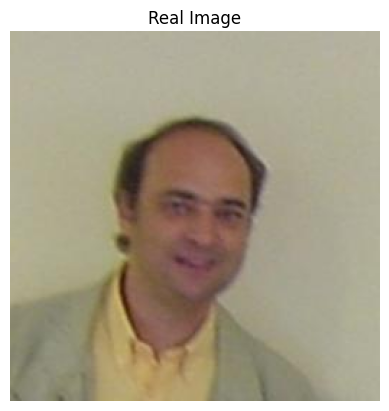

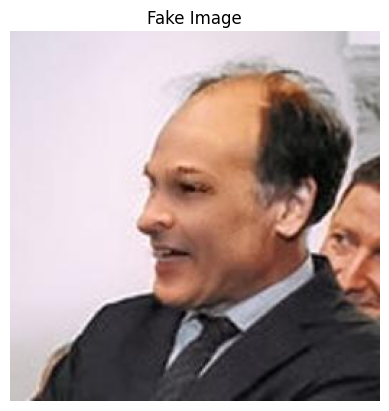

In [10]:
#Display Sample Images
import matplotlib.pyplot as plt
import cv2
import random

def show_sample_image(folder_path, title):
    img_name = random.choice(os.listdir(folder_path))
    img_path = os.path.join(folder_path, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

# ✅ Show one real and one fake image from Train dataset
show_sample_image(train_real, "Real Image")
show_sample_image(train_fake, "Fake Image")






In [11]:
#Preprocess Dataset for PyTorch
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# ✅ Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

# ✅ Load datasets
train_dataset = ImageFolder("dataset/Dataset/Train", transform=transform)
test_dataset = ImageFolder("dataset/Dataset/Test", transform=transform)
val_dataset = ImageFolder("dataset/Dataset/Validation", transform=transform)

# ✅ Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"✅ Training samples: {len(train_dataset)}")
print(f"✅ Testing samples: {len(test_dataset)}")
print(f"✅ Validation samples: {len(val_dataset)}")






✅ Training samples: 140002
✅ Testing samples: 10905
✅ Validation samples: 39428


In [12]:
#training and the ResNet model
# ✅ Import Necessary Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

# ✅ Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Define Data Transformations (with Augmentations)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),   # Augmentation for better generalization
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# ✅ Load Dataset
train_dataset = ImageFolder("dataset/Dataset/Train", transform=transform)
test_dataset = ImageFolder("dataset/Dataset/Test", transform=transform)
val_dataset = ImageFolder("dataset/Dataset/Validation", transform=transform)

# ✅ Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ Training samples: {len(train_dataset)}")
print(f"✅ Testing samples: {len(test_dataset)}")
print(f"✅ Validation samples: {len(val_dataset)}")

# ✅ Load Pre-trained ResNet18 Model
model = models.resnet18(pretrained=True)  # Load a pre-trained ResNet18
model.fc = nn.Linear(model.fc.in_features, 1)  # Modify last layer for binary classification
model = model.to(device)

# ✅ Define Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary classification loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lower LR for fine-tuning

# ✅ Training Loop
num_epochs = 10  # Increase epochs for better performance

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # Convert labels to float

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

print("✅ Training complete! 🎯")

# ✅ Evaluate Model
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        predictions = torch.round(torch.sigmoid(outputs))  # Convert logits to 0 or 1
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = (correct / total) * 100
print(f"✅ Test Accuracy: {accuracy:.2f}%")

# ✅ Save the Model
torch.save(model.state_dict(), "deepfake_model_resnet18.pth")
print("✅ Model saved successfully! 🎯")



Using device: cuda
✅ Training samples: 140002
✅ Testing samples: 10905
✅ Validation samples: 39428


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]


Epoch [1/10], Loss: 0.0774
Epoch [2/10], Loss: 0.0479
Epoch [3/10], Loss: 0.0403
Epoch [4/10], Loss: 0.0357
Epoch [5/10], Loss: 0.0327
Epoch [6/10], Loss: 0.0298
Epoch [7/10], Loss: 0.0273
Epoch [8/10], Loss: 0.0254
Epoch [9/10], Loss: 0.0240
Epoch [10/10], Loss: 0.0219
✅ Training complete! 🎯
✅ Test Accuracy: 91.20%
✅ Model saved successfully! 🎯


In [13]:
real_count = len(train_dataset.targets) - sum(train_dataset.targets)
fake_count = sum(train_dataset.targets)

print(f"Real Images: {real_count}, Fake Images: {fake_count}")


Real Images: 70001, Fake Images: 70001


In [15]:
MODEL_PATH = "deepfake_model_resnet18.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f"✅ Model saved successfully as {MODEL_PATH} 🎯")



✅ Model saved successfully as deepfake_model_resnet18.pth 🎯


In [16]:
from google.colab import files
files.download("deepfake_model_resnet18.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>